In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer.noise import NoiseModel

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor


In [2]:
def kpe(phase, shots, backend, args={}):
    '''
    Run Kitaev Phase Estimation algorithm.
        - phase: The phase that we want to estimate
        - shots: number of executions of each circuit
        - backend: we can run a simulation or run the code in a NISQ computer
        - args: parameters needed for the backend
    '''
    # FIRST CIRCUIT
    circ = QuantumCircuit(2, 1) # Create Quantum Circuit with 2 quantum register and 1 classical register
    circ.x(1) # Prepare the eigenstate
    circ.h(0)
    circ.cu1(2*np.pi*phase, 0, 1)
    circ.h(0)
    circ.measure(0, 0)
    result = None
    # Measure the first circuit 
    if backend.configuration().backend_name == 'qasm_simulator':
        result = execute(circ, backend=backend, shots=shots, **args).result()
    else:
        job_exp = execute(circ, backend=backend, shots=shots)
        job_monitor(job_exp)
        result = job_exp.result()
    counts = result.get_counts()
    if '0' not in counts.keys(): counts['0'] = 0
    if '1' not in counts.keys(): counts['1'] = 0
    p0 = counts['0']/shots
    
    # SECOND CIRCUIT
    circ = QuantumCircuit(2, 1) # Create Quantum Circuit with 2 quantum register and 1 classical register
    circ.x(1) # Prepare the eigenstate
    circ.h(0)
    circ.s(0)
    circ.cu1(2*np.pi*phase, 0, 1)
    circ.h(0)
    circ.measure(0, 0)
    
    # Measuring the second circuit 
    if backend.configuration().backend_name == 'qasm_simulator':
        result = execute(circ, backend=backend, shots=shots, **args).result()
    else:
        job_exp = execute(circ, backend=backend, shots=shots)
        job_monitor(job_exp)
        result = job_exp.result()
    counts = result.get_counts()
    if '0' not in counts.keys(): counts['0'] = 0
    if '1' not in counts.keys(): counts['1'] = 0
    p0p = counts['0']/shots
    
    # Getting a phase estimation
    est_phase = np.arctan2(1-2*p0p, 2*p0 - 1)/(2*np.pi)
    est_phase = 1 + est_phase if est_phase < 0 else est_phase
    return est_phase

def distance(n1, n2):
    '''
    Returns corresponding distance between two points. 
    In the phase space, 0 and 1 are the same. We have to think as if the interval
    has a circular shape, with the extremes connected
    '''
    aux = np.absolute(n1 - n2)
    return aux if aux < 0.5 else 1 - aux


# Accuracy vs runs

We will repeat the simulation n times for every fixed shots, and then compute the average accuracy.

In [33]:
t = 10
dt = 1
runs = 2**(np.arange(1, t+1, dt, dtype=int))
phase = 1/3
n = 100

## Simulation

In [34]:
accuracies = []
backend = Aer.get_backend('qasm_simulator')
for i in runs:
    aux = [distance(phase, kpe(phase, int(i), backend)) for j in range(n)]
    accuracies.append(np.mean(aux))

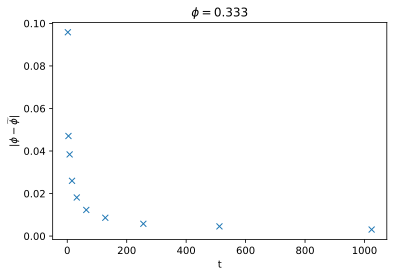

In [35]:
plt.plot(runs, accuracies, 'x')
plt.xlabel('t')

plt.ylabel(r'$|\phi - \widetilde{\phi}|$')
plt.title(r'$\phi = {}$'.format(round(phase, 3)))
plt.savefig('acc-vs-runs')

## Noisy Simulation

In [21]:
#---------- NOISY SIMULATION ----------------------------
# Build noise model from backend properties
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend_qc)

noise_model = NoiseModel.from_backend(backend_qc)

# Get coupling map from backend
coupling_map = backend_qc.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

#---------------------------------------------------------

ibmqfactory.load_account:WARNING:2020-05-02 18:09:22,773: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_essex


In [36]:

accuracies = []
backend = Aer.get_backend('qasm_simulator')
args = {'noise_model':noise_model, 'coupling_map':coupling_map, 'basis_gates':basis_gates}

for i in runs:
    aux = [distance(phase, kpe(phase, int(i), backend, args)) for j in range(n)]
    accuracies.append(np.mean(aux))
    

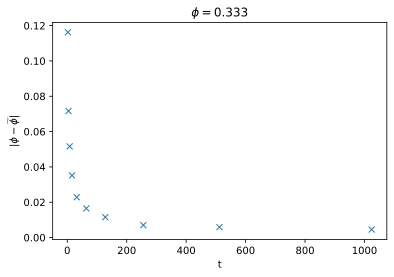

In [37]:
plt.plot(runs, accuracies, 'x')
x = np.linspace(1, t, 100)
plt.xlabel('t')
plt.ylabel(r'$|\phi - \widetilde{\phi}|$')
plt.title(r'$\phi = {}$'.format(round(phase, 3)))
plt.savefig('acc-vs-runs-noise')

## Running in a real QC

In [26]:
accuracies = []
n = 1
runs = 2**(np.array([1, 4, 7, 10]))
for i in runs:
    aux = [distance(phase, kpe(phase, int(i), backend_qc)) for j in range(n)]
    accuracies.append(np.mean(aux))

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


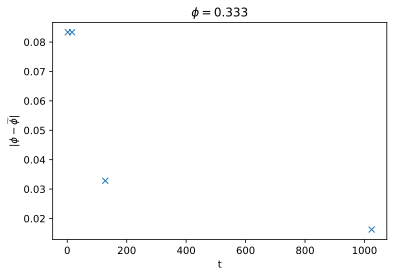

In [28]:
plt.plot(runs, accuracies, 'x')
x = np.linspace(1, t, 100)
plt.xlabel('t')
plt.ylabel(r'$|\phi - \widetilde{\phi}|$')
plt.title(r'$\phi = {}$'.format(round(phase, 3)))
plt.savefig('ibmq_essex')

# Accuracy vs Phase

Now, we will fix the number of runs (t = 10) and study the accuracy for a range of phases

In [12]:
phases = np.linspace(0, 0.9, 20)
t = 100
n = 100 
accuracies = []
for phase in phases:
    aux = [distance(phase, kpe(phase, t, backend, args)) for i in range(n)]
    accuracies.append(np.max(aux))       

([<matplotlib.axis.YTick at 0x7f6935c40190>,
 <a list of 5 Text yticklabel objects>)

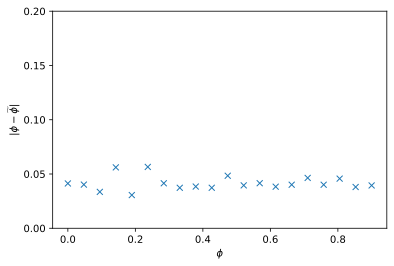

In [13]:
plt.plot(phases, accuracies, 'x')
plt.xlabel(r'$\phi$')
plt.ylim([0, 0.2])
plt.ylabel(r'$|\phi - \widetilde{\phi}|$')
plt.yticks(np.linspace(0, 0.2, 5))

In [5]:
# Get the circuit running on a real quantum computer

shots = 1024 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmqx2


least busy backend:  ibmq_16_melbourne
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


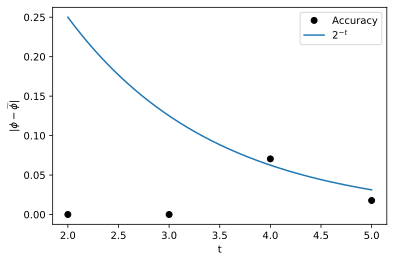

In [53]:
# Run in real quantum computer

t = 5

accuracies = np.zeros(t-1)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

for i in range(2, t+1):
    shots = int(np.ceil(t*np.log(i)))
    job_exp = execute(circ, backend=backend, shots=shots)
    job_monitor(job_exp)
    result = job_exp.result()
    counts = result.get_counts()
    est_phase = np.arctan(np.sqrt(counts['1']/counts['0']))/np.pi
    accuracies[i-2] = np.absolute(phase - est_phase)


x = range(2, t+1)
plt.ylabel(r'$|\phi - \widetilde{\phi}|$')
plt.xlabel('t')
plt.plot(x, accuracies, 'ko', label='Accuracy')
x1 = np.linspace(2, t, 1000)
plt.plot(x1, 2**(-x1), label=r'$2^{-t}$')
plt.legend()